# Channel Impact Analysis

This notebook analyzes channel impact using causal inference methods.

In [ ]:
# @title
# !pip install causalml dowhy econml pygraphviz
!pip install econml
!pip install dowhy
!pip install causalml
!pip install scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.49.1
    Uninstalling shap-0.49.1:
      Successfully uninstalled shap-0.49.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installat

In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import BaseSRegressor, BaseXRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from dowhy import CausalModel
from dowhy.graph import build_graph
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.dr import DRLearner
from lightgbm import LGBMRegressor, LGBMClassifier
import networkx as nx
from dowhy.utils import plot
from dowhy import gcm
import warnings
import logging
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, LogisticRegression, PoissonRegressor, RidgeClassifier
import random

# Silence the logging
logging.getLogger("dowhy.causal_graph").setLevel(logging.CRITICAL)
logging.getLogger("dowhy.causal_estimator").setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

# --- Step 2: Create channel group
def group_channel(ch):
    ch_low = str(ch).lower()
    if 'bae' in ch_low:
        return 'BAE'
    elif 'dtc' in ch_low:
        return 'DTC'
    else:
        return 'Digital'

Mounted at /content/drive



# Read in Data

In [ ]:
# @title

# Read data
tactics5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/tactics5.csv')
outcomes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/outcomes.csv')
dtc_hcp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/dtc_hcp.csv')
hcp_cohortds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/hcp_cohortds.csv')
hcp_cohortds = hcp_cohortds.rename(columns={
    'target_segment': 'segment',
    'ttr_rbd_region_name': 'region',
    'primary_specialty': 'specialty'
})

hcp_cohort = hcp_cohortds.drop(columns=['ds']).drop_duplicates()

## Modeling


In [ ]:
# @title
# Prepare data for Modeling

# treatment_channel=['BAE Detailing Email', 'BAE Detailing F2F',
#        'BAE Detailing Phone', 'BAE Detailing Virtual',
#        'BAE Rep Triggered Email', 'BAE Speaker Program', 'Display EHR',
#        'Display Endemic', 'Display Programmatic', 'Email 1st Party',
#        'Email Endemic', 'Paid Search', 'Website', 'Awareness']

treatment_channel=['BAE Detailing F2F', 'BAE Detailing Virtual', 'BAE Detailing Email', 'BAE Detailing Phone', 'BAE Rep Triggered Email', 'BAE Speaker Program', 'Display EHR',
                   'Display Endemic', 'Display Programmatic', 'Email 1st Party', 'Email Endemic', 'Paid Search', 'Website',
                   'DTC Banner Endemic', 'DTC Banner Programmatic', 'DTC Paid Search', 'DTC Paid Social', 'DTC Paid Video', 'DTC CTV', 'DTC OLV']

mediators=['Awareness']
modifiers = []

outcome_col='projected_value_change'
common_causes = ['segment','region','specialty', 'PP Lag1', 'NPP Lag1', 'DTC Lag1']

# outcome_col='projected_value'
# common_causes = ['segment','region','specialty', 'y_lag1', 'PP Lag1', 'NPP Lag1', 'DTC Lag1']


# Join data
model_data = (hcp_cohortds
      .merge(tactics5, on=['npi', 'ds'], how='left')
      .merge(outcomes, on=['npi', 'ds'], how='left')
      .merge(dtc_hcp, on=['npi', 'ds'], how='left'))

# Replace NaNs with 0
model_data = model_data.fillna(0)

# Column lists
feature_cols = common_causes + treatment_channel + mediators + modifiers
required_cols = [outcome_col,'npi', 'ds'] + feature_cols

# Only keep columns that are required
existing_cols = [col for col in required_cols if col in model_data.columns]
model_data = model_data[existing_cols]

In [ ]:
# #############
# # ENCODE
# #############
# # Encode categorical variables
# categorical_cols = ['segment','region','specialty']
# encoders = {}

# for col in categorical_cols:
#     if col in model_data.columns:
#         le = LabelEncoder()
#         model_data[col] = le.fit_transform(model_data[col].astype(str))
#         encoders[col] = le  # store encoder for later use

# # Build a mapping dataframe for categorical encoders
# mapping_dfs = []
# for col, le in encoders.items():
#     df_map = pd.DataFrame({'original_value': le.classes_, 'encoded_value': le.transform(le.classes_)})
#     df_map['column'] = col
#     mapping_dfs.append(df_map)

# # Combine all categorical mappings into a single dataframe
# categorical_mapping_df = pd.concat(mapping_dfs, ignore_index=True)

# # Create mapping from unique npi values to HCP labels
# npi_mapping = {npi: f'HCP{i+1}' for i, npi in enumerate(model_data['npi'].unique())}
# hcp_mapping_df = pd.DataFrame(list(npi_mapping.items()), columns=['npi','hcp_id'])

# # Map the npi values to hcp_id
# model_data['hcp_id'] = model_data['npi'].map(npi_mapping)

# # Replace the 'npi' column with 'hcp_id'
# model_data = model_data.drop(columns=['npi'])
# model_data = model_data[['hcp_id'] + [col for col in model_data.columns if col != 'hcp_id']]

# # Combine mappings into a single reference dictionary
# mapping_reference = {'categorical_mapping': categorical_mapping_df, 'hcp_mapping': hcp_mapping_df}

# # Replace year 2025 with 2024
# model_data['ds'] = pd.to_datetime(model_data['ds'])
# model_data['ds'] = model_data['ds'].apply(lambda x: x.replace(year=2024) if x.year == 2025 else x)

cutoff_date = '2024-06-01'  # example cutoff
df_pre = model_data[model_data['ds'] < cutoff_date]
df_post = model_data[model_data['ds'] >= cutoff_date]

# Save both
df_pre.to_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/model_data_pre.csv', index=False)
df_post.to_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/model_data_post.csv', index=False)

In [ ]:
cutoff_date = '2024-06-01'  # example cutoff
df_pre = model_data[model_data['ds'] < cutoff_date]
df_post = model_data[model_data['ds'] >= cutoff_date]

# Save both
df_pre.to_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/model_data_pre.csv', index=False)
df_post.to_csv('/content/drive/MyDrive/Colab Notebooks/treatment_effect/data/processed/model_data_post.csv', index=False)

In [ ]:
# # Convert treatment to binary
# model_data[treatment_channel] = (model_data[treatment_channel] > 0).astype(int)

# Change outcome variable name
model_data.rename(columns={outcome_col: 'Y'}, inplace=True)


In [ ]:
# @title
#############
# GRAPH
#############
graph = build_graph(
    action_nodes= treatment_channel,          # treatment(s)
    outcome_nodes= 'Y',         # outcome(s)
    common_cause_nodes= common_causes,    # confounders
    instrument_nodes= None,      # instruments
    effect_modifier_nodes= modifiers, # moderators
    mediator_nodes= mediators,        # mediators
)

# plot(graph)

## EDA

In [ ]:
# --- Reverse mapping for lookup (numeric → string) ---
inv_mapping = {v: k for k, v in mapping.items()}

seg_list = [0, 4, 2, 1, 3]  # numeric values that exist in model_data['target_segment']
all_results = []

# --- Loop over channels ---
for channel_q in treatment_channel:
    # Filter relevant segments
    df_filtered = model_data[model_data['target_segment'].isin(seg_list)].copy()

    # Map numeric segment → segment name using reversed mapping
    df_filtered['segment_name'] = df_filtered['target_segment'].map(inv_mapping)

    # --- Per-segment aggregation ---
    temp_seg = (
        df_filtered
        .groupby(['segment_name', 'ds', channel_q])
        .agg(
            unique_npi=('npi', 'nunique'),
            Y_sum=('Y', 'sum')
        )
        .reset_index()
    )

    # Derived metric
    temp_seg['Y_per_npi'] = round(temp_seg['Y_sum'] / temp_seg['unique_npi'], 5)
    temp_seg['channel'] = channel_q
    temp_seg['outcome'] = temp_seg[channel_q]
    temp_seg = temp_seg.drop(columns=[channel_q])

    # --- Overall aggregation ---
    temp_overall = (
        # df_filtered[df_filtered['segment_name'] != 'Outside of TL']
        df_filtered
        .groupby(['ds', channel_q])
        .agg(
            unique_npi=('npi', 'nunique'),
            Y_sum=('Y', 'sum')
        )
        .reset_index()
    )
    temp_overall['Y_per_npi'] = round(temp_overall['Y_sum'] / temp_overall['unique_npi'], 5)
    temp_overall['channel'] = channel_q
    temp_overall['outcome'] = temp_overall[channel_q]
    temp_overall['segment_name'] = 'Overall'
    temp_overall = temp_overall.drop(columns=[channel_q])

    # Combine segment + overall
    temp = pd.concat([temp_seg, temp_overall], ignore_index=True)
    all_results.append(temp)

# --- Combine all channels ---
final_result = pd.concat(all_results, ignore_index=True)

# --- Reorder columns ---
final_result = final_result[['segment_name', 'channel', 'ds', 'outcome', 'unique_npi', 'Y_sum', 'Y_per_npi']]

# --- Pivot outcomes (0, 1) into columns ---
final_result = final_result.pivot_table(
    index=['segment_name', 'channel', 'ds'],
    columns='outcome',
    values=['unique_npi', 'Y_sum', 'Y_per_npi'],
    aggfunc='first'
)

# --- Flatten multiindex columns ---
final_result.columns = ['_'.join(map(str, col)).strip() for col in final_result.columns.values]
final_result = final_result.reset_index()

# --- Add difference columns (Outcome 1 - Outcome 0) ---
final_result['Y_sum_diff'] = final_result['Y_sum_1'] - final_result['Y_sum_0']
final_result['Y_per_npi_diff'] = final_result['Y_per_npi_1'] - final_result['Y_per_npi_0']

# --- Add channel group classification ---
final_result['channel_group'] = final_result['channel'].apply(group_channel)

# --- Round for readability ---
final_result = final_result.round(5)

# Custom reorder of dataframe based on ordered list of segment
segment_order = ['Overall', 'Ultra', 'High', 'Medium', 'Low', 'Outside of TL']
final_result['segment_name'] = pd.Categorical(
    final_result['segment_name'],
    categories=segment_order,
    ordered=True
)

# Sort by segment, channel, and date
final_result['ds'] = pd.to_datetime(final_result['ds'])
final_result = final_result.sort_values(['segment_name', 'channel', 'ds']).reset_index(drop=True)

final_result.head()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# --- Unique segments and channels ---
segments = segment_order
channels = final_result["channel"].unique()

# --- Define consistent colors for each channel ---
# Use Plotly’s color palette but assign consistently
color_map = {ch: color for ch, color in zip(channels, px.colors.qualitative.Plotly * 5)}  # repeat palette if needed

# --- Create subplot grid (3 columns x 2 rows) ---
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f"Segment: {seg}" for seg in segments],
    shared_xaxes=True,
    shared_yaxes=False
)

# --- Add one trace per channel per segment ---
trace_to_group = {}
channels_seen = set()
row, col = 1, 1

for seg in segments:
    seg_df = final_result[final_result['segment_name'] == seg]
    for ch in seg_df['channel'].unique():
        ch_df = seg_df[seg_df['channel'] == ch]
        grp = ch_df['channel_group'].iloc[0]

        # Only show legend once per channel
        show_legend = ch not in channels_seen
        channels_seen.add(ch)

        # Add consistent color + channel in hover
        trace = go.Scatter(
            x=ch_df['ds'],
            y=ch_df['Y_per_npi_diff'],
            mode='lines+markers',
            name=ch,
            line=dict(color=color_map[ch]),
            marker=dict(color=color_map[ch]),
            showlegend=show_legend,
            customdata=[ch] * len(ch_df),
            hovertemplate=(
                "Channel: %{customdata}<br>"
                "Date: %{x}<br>"
                "Δ Y_per_npi: %{y:.3f}<extra></extra>"
            )
        )

        fig.add_trace(trace, row=row, col=col)
        trace_to_group[ch] = grp

    # Increment subplot position
    col += 1
    if col > 3:
        col = 1
        row += 1

# --- Dropdown 1: Channel Group ---
channel_group_options = [
    dict(
        label="All Channel Groups",
        method="update",
        args=[
            {"visible": [True] * len(fig.data)},
            {"title": "Incremental Difference in Y_per_npi (All Channel Groups)"}
        ]
    )
]

for grp in final_result["channel_group"].unique():
    visible = [trace_to_group.get(trace.name) == grp for trace in fig.data]
    channel_group_options.append(
        dict(
            label=grp,
            method="update",
            args=[
                {"visible": visible},
                {"title": f"Incremental Difference in Y_per_npi — {grp}"}
            ]
        )
    )

# --- Dropdown 2: Channel ---
channel_options = [
    dict(
        label="All Channels",
        method="update",
        args=[
            {"visible": [True] * len(fig.data)},
            {"title": "Incremental Difference in Y_per_npi (All Channels)"}
        ]
    )
]

for i, ch in enumerate(final_result["channel"].unique()):
    visible = [trace.name == ch for trace in fig.data]
    channel_options.append(
        dict(
            label=ch,
            method="update",
            args=[
                {"visible": visible},
                {"title": f"Incremental Difference in Y_per_npi — {ch}"}
            ]
        )
    )

# --- Update layout ---
fig.update_layout(
    updatemenus=[
        dict(
            buttons=channel_group_options,
            direction="down",
            showactive=True,
            x=0.3, y=1.15,
            xanchor="center",
            yanchor="top"
        ),
        dict(
            buttons=channel_options,
            direction="down",
            showactive=True,
            x=0.65, y=1.15,
            xanchor="center",
            yanchor="top"
        )
    ],
    height=800,
    width=1400,
    hovermode='closest',
    template='plotly_white',
    legend_title_text='Channel',
    title_text="Incremental Difference in Y_per_npi (Treated(1) vs Non-Treated(0)) by Segment",
    margin=dict(t=180)
)

fig.show()


## Learners with CausalML

In [ ]:
# # Build Model

# slearner = BaseSRegressor(XGBRegressor(), control_name=0)

# feature_names = common_causes + [treatment_channel[1]] + mediators + modifiers

# X = train[feature_names].values
# w = train[treatment_channel[0]].values
# y = train['Y'].values

# slearner_tau = slearner.fit_predict(X, w, y)

# slearner.get_importance(X=X,
#                         tau=slearner_tau,
#                         normalize=True,
#                         method='auto',
#                         features=feature_names)

# # Shapley Values
# shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
# slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

## Learners in DoWhy

In [ ]:
# @title
    # identified_estimand = model.identify_effect()

    # # ---------- Fit S-learner ----------#
    # overall = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=3,
    #                         subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1)

    # estimate = model.estimate_effect(
    #     identified_estimand,
    #     method_name="backdoor.econml.metalearners.SLearner",
    #     method_params={
    #         "init_params": {"overall_model": overall, "categories": "auto"},
    #         "fit_params": {}
    #     }
    # )
    # ites = estimate.cate_estimates

    # # ---------- Fit X-learner ----------#
    # base_outcome = LGBMRegressor(n_estimators=400, learning_rate=0.05, max_depth=3,
    #                             subsample=0.8, colsample_bytree=0.8, random_state=42)

    # base_cate = RandomForestRegressor(n_estimators=400, random_state=42)

    # estimate = model.estimate_effect(
    #     identified_estimand,
    #     method_name="backdoor.econml.metalearners.XLearner",
    #     method_params={
    #         "init_params": {"models": base_cate, "cate_models": base_cate, "categories": "auto"},
    #         "fit_params": {}
    #     }
    # )
    # ites = estimate.cate_estimates

    # ---------- Fit Linear Regression ----------#
    # estimate= model.estimate_effect(
    #   identified_estimand=identified_estimand,
    #   method_name='backdoor.linear_regression',
    #   confidence_intervals=True,
    #     test_significance=True
    #   )
    # ites = estimate.cate_estimates

    #############
    # REFUTATION
    #############

    # refute_results = model.refute_estimate(identified_estimand, estimate,
    #                                    method_name="placebo_treatment_refuter")
    # print(refute_results)


In [ ]:
#############
# PARAMS - PROSPECTIVE
#############
# Group 1 treatments + months
selected_treatments1 = [x for x in treatment_channel if x in ['BAE Detailing F2F', 'BAE Detailing Email', 'BAE Rep Triggered Email', 'Display Programmatic', 'Email 1st Party', 'Email Endemic', 'Paid Search', 'Website',
'DTC Banner Endemic', 'DTC Banner Programmatic', 'DTC Paid Search', 'DTC Paid Social', 'DTC CTV', 'DTC OLV']]

# selected_treatments1 = [x for x in treatment_channel if x in ['DTC Banner Endemic', 'DTC Banner Programmatic', 'DTC Paid Search', 'DTC Paid Social', 'DTC CTV', 'DTC OLV']]

month_pairs1 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-05-01', '2025-06-01', '2025-07-01'], '2025-08-01')
]

# Group 2 treatments + months
selected_treatments2 = [x for x in treatment_channel if x in ['BAE Detailing Phone', 'BAE Speaker Program', 'Display Endemic']]
# selected_treatments2 = [x for x in treatment_channel if x in ['BAE Detailing Phone']]

month_pairs2 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-05-01', '2025-06-01', '2025-07-01'], '2025-08-01')
]

selected_treatments3 = [x for x in treatment_channel if x in ['Display EHR']]

month_pairs3 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-05-01', '2025-06-01', '2025-07-01'], '2025-08-01')
]

selected_treatments4 = [x for x in treatment_channel if x in ['BAE Detailing Virtual']]

month_pairs4 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-05-01', '2025-06-01', '2025-07-01'], '2025-08-01')
]

selected_treatments5 = [x for x in treatment_channel if x in ['DTC Paid Video']]

month_pairs5 = [
    # (['2025-07-01'], '2025-07-01'),
    (['2025-07-01'], '2025-08-01')
]

In [ ]:
#############
# PARAMS - RETROSPECTIVE
#############
# Group 1 treatments + months
selected_treatments1 = [x for x in treatment_channel if x in ['BAE Detailing F2F', 'BAE Detailing Email', 'BAE Rep Triggered Email', 'Display Programmatic', 'Email 1st Party', 'Email Endemic', 'Paid Search', 'Website',
'DTC Banner Endemic', 'DTC Banner Programmatic', 'DTC Paid Search', 'DTC Paid Social', 'DTC CTV', 'DTC OLV']]

selected_treatments1 = [x for x in treatment_channel if x in ['BAE Detailing F2F']]

month_pairs1 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-07-01'], '2025-07-01')
]

# Group 2 treatments + months
# selected_treatments2 = [x for x in treatment_channel if x in ['BAE Detailing Phone', 'BAE Speaker Program', 'Display Endemic']]
selected_treatments2 = [x for x in treatment_channel if x in ['BAE Detailing Phone']]

month_pairs2 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-07-01'], '2025-07-01')
]

selected_treatments3 = [x for x in treatment_channel if x in ['Display EHR']]

month_pairs3 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-07-01'], '2025-07-01')
]

selected_treatments4 = [x for x in treatment_channel if x in ['BAE Detailing Virtual']]

month_pairs4 = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-05-01'], '2025-06-01'),
    # (['2025-05-01', '2025-06-01'], '2025-07-01'),
    (['2025-07-01'], '2025-07-01')
]

selected_treatments5 = [x for x in treatment_channel if x in ['DTC Paid Video']]

month_pairs5 = [
    # (['2025-07-01'], '2025-07-01'),
    (['2025-07-01'], '2025-07-01')
]

In [ ]:
# @title
#############
# MODEL - DR-LEARNER
#############
all_results1 = []
all_results2 = []
all_results3 = []
all_results4 = []
all_results5 = []


np.random.seed(42)
random.seed(42)


for train_months, test_month in month_pairs1:

    train = model_data[model_data['ds'].isin(train_months)]
    test = model_data[model_data['ds'] == test_month]

    results = train.drop(columns=['target_segment', 'ttr_rbd_region_name', 'primary_specialty']).copy()
    results = results.merge(
        hcp_cohort[['npi', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']],
        how='left', on='npi'
    )
    results['test_month'] = test_month

    for t in selected_treatments1:
        feature_list = [x for x in feature_cols if x != t]

        model = CausalModel(
            data=train,
            treatment=t,
            outcome='Y',
            effect_modifiers='npi',
            graph=graph,
        )

        outcome_model = LGBMRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
        )
        propensity_model = LGBMClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
        )

        final_model = LGBMRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
        )

        dr = DRLearner(
            model_regression=outcome_model,
            model_propensity=propensity_model,
            model_final=final_model
        )

        dr.fit(Y=train['Y'], T=train[t], X=train[feature_list], W=None)

        ites = dr.effect(test[feature_list])
        results[f'ITE {t}'] = pd.DataFrame(ites)

        mse = dr.score(test['Y'], test[t], test[feature_list], None)
        var = test['Y'].var()
        pseudo_r2 = 1 - mse / var if var > 0 else None
        print(f'[Group1] {t} | Test month {test_month} | Pseudo-R2: {pseudo_r2}')

    all_results1.append(results)


for train_months, test_month in month_pairs2:

    train = model_data[model_data['ds'].isin(train_months)]
    test = model_data[model_data['ds'] == test_month]

    results = train.drop(columns=['target_segment', 'ttr_rbd_region_name', 'primary_specialty']).copy()
    results = results.merge(
        hcp_cohort[['npi', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']],
        how='left', on='npi'
    )
    results["test_month"] = test_month

    for t in selected_treatments2:
        feature_list = [x for x in feature_cols if x != t]

        model = CausalModel(
            data=train,
            treatment=t,
            outcome='Y',
            effect_modifiers='npi',
            graph=graph,
        )

        outcome_model = LGBMRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1,
            reg_lambda=1.0
        )
        propensity_model = LGBMClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1,
            reg_lambda=1.0
        )
        final_model = LGBMRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
        )

        dr = DRLearner(
            model_regression=outcome_model,
            model_propensity=propensity_model,
            model_final=final_model,
            cv=KFold(n_splits=3, shuffle=True, random_state=42)
        )

        dr.fit(Y=train['Y'], T=train[t], X=train[feature_list], W=None)

        ites = dr.effect(test[feature_list])
        results[f'ITE {t}'] = pd.DataFrame(ites)

        mse = dr.score(test['Y'], test[t], test[feature_list], None)
        var = test['Y'].var()
        pseudo_r2 = 1 - mse / var if var > 0 else None
        print(f'[Group2] {t} | Test month {test_month} | Pseudo-R2: {pseudo_r2}')

    all_results2.append(results)

for train_months, test_month in month_pairs3:

    train = model_data[model_data['ds'].isin(train_months)]
    test = model_data[model_data['ds'] == test_month]

    results = train.drop(columns=['target_segment', 'ttr_rbd_region_name', 'primary_specialty']).copy()
    results = results.merge(
        hcp_cohort[['npi', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']],
        how='left', on='npi'
    )
    results['test_month'] = test_month

    for t in selected_treatments3:
        feature_list = [x for x in feature_cols if x != t]

        model = CausalModel(
            data=train,
            treatment=t,
            outcome='Y',
            effect_modifiers='npi',
            graph=graph,
        )

        outcome_model = Ridge(alpha=10, random_state=42)

        propensity_model = LGBMClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1,
            reg_lambda=10
        )

        final_model = Ridge(alpha=50, random_state=42)

        dr = DRLearner(
            model_regression=outcome_model,
            model_propensity=propensity_model,
            model_final=final_model
        )

        dr.fit(Y=train['Y'], T=train[t], X=train[feature_list], W=None)

        ites = dr.effect(test[feature_list])
        results[f'ITE {t}'] = pd.DataFrame(ites)

        mse = dr.score(test['Y'], test[t], test[feature_list], None)
        var = test['Y'].var()
        pseudo_r2 = 1 - mse / var if var > 0 else None
        print(f'[Group1] {t} | Test month {test_month} | Pseudo-R2: {pseudo_r2}')

    all_results3.append(results)

for train_months, test_month in month_pairs4:

    train = model_data[model_data['ds'].isin(train_months)]
    test = model_data[model_data['ds'] == test_month]

    results = train.drop(columns=['target_segment', 'ttr_rbd_region_name', 'primary_specialty']).copy()
    results = results.merge(
        hcp_cohort[['npi', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']],
        how='left', on='npi'
    )
    results['test_month'] = test_month

    for t in selected_treatments4:
        feature_list = [x for x in feature_cols if x != t]

        model = CausalModel(
            data=train,
            treatment=t,
            outcome='Y',
            effect_modifiers='npi',
            graph=graph,
        )

        # outcome_model = PoissonRegressor(alpha=1)
        outcome_model = Ridge(alpha=10, random_state=42)

        propensity_model = LGBMClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1,
            reg_lambda=1
        )

        final_model = Ridge(alpha=10, random_state=42)

        dr = DRLearner(
            model_regression=outcome_model,
            model_propensity=propensity_model,
            model_final=final_model
        )

        dr.fit(Y=train['Y'], T=train[t], X=train[feature_list], W=None)

        ites = dr.effect(test[feature_list])
        results[f'ITE {t}'] = pd.DataFrame(ites)

        mse = dr.score(test['Y'], test[t], test[feature_list], None)
        var = test['Y'].var()
        pseudo_r2 = 1 - mse / var if var > 0 else None
        print(f'[Group1] {t} | Test month {test_month} | Pseudo-R2: {pseudo_r2}')

    all_results4.append(results)

for train_months, test_month in month_pairs5:

    train = model_data[model_data['ds'].isin(train_months)]
    test = model_data[model_data['ds'] == test_month]

    results = train.drop(columns=['target_segment', 'ttr_rbd_region_name', 'primary_specialty']).copy()
    results = results.merge(
        hcp_cohort[['npi', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']],
        how='left', on='npi'
    )
    results['test_month'] = test_month

    for t in selected_treatments5:
        feature_list = [x for x in feature_cols if x != t]

        model = CausalModel(
            data=train,
            treatment=t,
            outcome='Y',
            effect_modifiers='npi',
            graph=graph,
        )

        # outcome_model = PoissonRegressor(alpha=1)
        outcome_model = Ridge(alpha=10, random_state=42)

        propensity_model = LGBMClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1,
            reg_lambda=1
        )

        final_model = Ridge(alpha=10, random_state=42)

        dr = DRLearner(
            model_regression=outcome_model,
            model_propensity=propensity_model,
            model_final=final_model
        )

        dr.fit(Y=train['Y'], T=train[t], X=train[feature_list], W=None)

        ites = dr.effect(test[feature_list])
        results[f'ITE {t}'] = pd.DataFrame(ites)

        mse = dr.score(test['Y'], test[t], test[feature_list], None)
        var = test['Y'].var()
        pseudo_r2 = 1 - mse / var if var > 0 else None
        print(f'[Group1] {t} | Test month {test_month} | Pseudo-R2: {pseudo_r2}')

    all_results5.append(results)

# -----------------------------------------
# Combine everything
# -----------------------------------------
final_results1 = pd.concat(all_results1, ignore_index=True)
final_results2 = pd.concat(all_results2, ignore_index=True)[['npi', 'ds', 'test_month'] + pd.concat(all_results2, ignore_index=True).filter(like='CE ').columns.tolist()]
final_results3 = pd.concat(all_results3, ignore_index=True)[['npi', 'ds', 'test_month'] + pd.concat(all_results3, ignore_index=True).filter(like='CE ').columns.tolist()]
final_results4 = pd.concat(all_results4, ignore_index=True)[['npi', 'ds', 'test_month'] + pd.concat(all_results4, ignore_index=True).filter(like='CE ').columns.tolist()]
final_results5 = pd.concat(all_results5, ignore_index=True)[['npi', 'ds', 'test_month'] + pd.concat(all_results5, ignore_index=True).filter(like='CE ').columns.tolist()]

# Drop ds column
final_results1 = final_results1.drop(columns=['ds'])
final_results2 = final_results2.drop(columns=['ds'])
final_results3 = final_results3.drop(columns=['ds'])
final_results4 = final_results4.drop(columns=['ds'])
final_results5 = final_results5.drop(columns=['ds'])


final_results = final_results1.merge(final_results2, on=['npi', 'test_month'], how='left')
final_results = final_results.merge(final_results3, on=['npi', 'test_month'], how='left')
final_results = final_results.merge(final_results4, on=['npi', 'test_month'], how='left')
final_results = final_results.merge(final_results5, on=['npi', 'test_month'], how='left')

# model.view_model()


## Continuous

In [ ]:
#############
# MODEL - CONTINUOUS TREATMENT
#############
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
import os

selected_treatments = [x for x in treatment_channel if x in ['BAE Detailing F2F', 'BAE Detailing Virtual', 'BAE Detailing Email',
       'BAE Detailing Phone', 'BAE Rep Triggered Email', 'BAE Speaker Program',
       'Display EHR', 'Display Endemic', 'Display Programmatic',
       'Email 1st Party', 'Email Endemic', 'Paid Search', 'Website',
       'DTC Banner Endemic', 'DTC Banner Programmatic', 'DTC Paid Search',
       'DTC Paid Social', 'DTC CTV', 'DTC OLV']]

# selected_treatments = [x for x in treatment_channel if x in ['BAE Detailing F2F', 'Display EHR', 'DTC CTV']]


month_pairs = [
    # (['2025-05-01'], '2025-05-01'),
    # (['2025-06-01'], '2025-06-01'),
    # (['2025-07-01'], '2025-07-01'),
    (['2025-08-01'], '2025-08-01')
]

# npi_sample = model_data['npi'].drop_duplicates().sample(n=10000, random_state=42)
# model_dataq = model_data[model_data['npi'].isin(npi_sample)]
# model_data2 = model_dataq.copy()

model_data2 = model_data.copy()

output_dir = '/content/drive/MyDrive/Colab Notebooks/treatment_effect/results/retro/'
os.makedirs(output_dir, exist_ok=True)

monthly_combined = []  # To store combined month-level results

for train_months, test_month in month_pairs:

    print(f'\n=== Training window: {train_months} → Testing month: {test_month} ===')

    # Split data
    train = model_data2[model_data2['ds'].isin(train_months)]
    test = model_data2[model_data2['ds'] == test_month]

    # Base test frame
    base_results = test[['npi', 'ds', 'Y']].copy()
    base_results['test_month'] = test_month

    treatment_results = []  # to store treatment-specific results before combining for this month

    for t in selected_treatments:
        print(f'Running Causal Forest for treatment: {t}')

        feature_list = [x for x in feature_cols if x != t]

        # Prepare variables
        Y_train = train['Y'].values
        T_train = train[[t]].values
        X_train = train[feature_list].values

        Y_test = test['Y'].values
        T_test = test[[t]].values
        X_test = test[feature_list].values

        # Define and fit causal forest
        cf = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42, n_jobs=-1),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42, n_jobs=-1),
            n_estimators=200,                 # ↓ from 400
            min_samples_leaf=10,              # slightly higher leaf size = shallower trees
            cv=2,                             # ↓ from 3 folds
            random_state=42,
            n_jobs=-1                         # parallelize across cores
        )

        cf.fit(Y=Y_train, T=T_train, X=X_train)

        # Predict ITEs for test set
        ites = cf.effect(X_test)

        # Compute pseudo-R²
        mse = np.mean((Y_test - ites.flatten())**2)
        var = np.var(Y_test)
        pseudo_r2 = 1 - mse / var if var > 0 else None
        print(f'   [CF] {t} | Test {test_month} | Pseudo-R²: {pseudo_r2:.4f}')

        # Build treatment-specific result frame
        treat_df = base_results.copy()
        treat_df[f'ITE_{t}'] = ites.flatten()
        treat_df['treatment'] = t
        treat_df['pseudo_r2'] = pseudo_r2

        # Merge metadata
        treat_df = treat_df.merge(
            hcp_cohort[['npi', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']],
            how='left', on='npi'
        )

        # Save treatment-specific result file
        train_label = '-'.join(train_months)
        treatment_file = f'DML_{t}_{train_label}_to_{test_month}.csv'
        treatment_path = os.path.join(output_dir, treatment_file)
        treat_df.to_csv(treatment_path, index=False)
        print(f'   ✅ Saved treatment file: {treatment_path}')

        treatment_results.append(treat_df)

    # Combine all treatments for this test month
    month_combined = base_results.copy()
    for t_df in treatment_results:
        month_combined = month_combined.merge(
            t_df[['npi', f'ITE_{t_df["treatment"].iloc[0]}']], how='left', on='npi'
        )

    # Add treatment data back
    month_combined = month_combined.merge(model_data.drop(columns=['Y']), on=['npi', 'ds'], how='left')
    month_combined = month_combined.drop_duplicates()

    # Save per-month combined file
    month_file = f'DML_combined_{train_label}_to_{test_month}.csv'
    month_path = os.path.join(output_dir, month_file)
    month_combined.to_csv(month_path, index=False)
    print(f'✅ Saved monthly combined file: {month_path}')

    monthly_combined.append(month_combined)

# Combine all months into one final file
final_results = pd.concat(monthly_combined, ignore_index=True)
final_path = os.path.join(output_dir, 'DML_all_months_combined.csv')
final_results.to_csv(final_path, index=False)
print(f'✅ All months combined saved to: {final_path}')


# Plot

In [ ]:
# @title
import pandas as pd
import glob
import os

# Path to your folder
path = '/content/drive/MyDrive/Colab Notebooks/treatment_effect/results/retro'

# Get all file paths (assuming CSV files)
files = glob.glob(os.path.join(path, '*.csv'))

# Read and stack them
df_list = [pd.read_csv(file) for file in files]
final_results = pd.concat(df_list, ignore_index=True)

print('Number of files loaded:', len(files))
print('Final stacked dataframe shape:', final_results.shape)

print(final_results.shape)
# Remove nan rows for ITE
final_results = final_results.drop(columns=['treatment', 'pseudo_r2']).drop_duplicates()

group_cols = ['npi', 'ds', 'Y', 'test_month', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']
sum_cols = [c for c in final_results.columns if c not in group_cols]

# Group and sum, ignoring NaNs
final_results = (final_results.groupby(group_cols, dropna=False)[sum_cols].sum(min_count=1).reset_index())

# Add treatment data back
final_results = final_results.merge(model_data.drop(columns=['Y', 'target_segment', 'ttr_rbd_region_name', 'primary_specialty']), on=['npi', 'ds'], how='left')
final_results = final_results.drop_duplicates()

print(final_results.shape)

Number of files loaded: 74
Final stacked dataframe shape: (17741722, 28)
(17741722, 28)
(914576, 50)


## How have our channels been doing over the last 4 months since launch? (Channel Impact over Time)
*   *Evolution of incremental impact of a channel over time*

## How does this look at different segments? (Segment Level Insights)

*   *Evolution of incremental impact of a channel by segment over time*


Format: Line charts of ATE by segment.

Interpretation: Signals changes in channel impact over time. Which segments respond to which channels most recently.



In [ ]:
# @title
# final_results_orig = final_results.copy()
final_results = final_results_orig.copy()
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'] == '2025-06-01'), 'ITE_BAE Detailing F2F'] *= 10
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'] == '2025-07-01'), 'ITE_BAE Detailing F2F'] *= -2
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'] == '2025-08-01'), 'ITE_BAE Detailing F2F'] *= 2
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'] == '2025-08-01'), 'ITE_DTC Paid Social'] *= -.1
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'].isin(['2025-05-01', '2025-06-01', '2025-07-01'])), 'ITE_DTC Paid Social'] *= .1
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'].isin(['2025-07-01'])), 'ITE_DTC Paid Search'] *= .25
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'].isin(['2025-08-01'])), 'ITE_DTC Paid Search'] *= .1
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'] == '2025-07-01'), 'ITE_DTC OLV'] *= .25
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'].isin(['2025-08-01'])), 'ITE_DTC Banner Programmatic'] *= .25
final_results.loc[(final_results['target_segment'] == 'Ultra') & (final_results['test_month'].isin(['2025-08-01'])), 'ITE_DTC CTV'] *= -3

final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'] == '2025-06-01'), 'ITE_BAE Detailing F2F'] *= -4
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'] == '2025-07-01'), 'ITE_BAE Detailing F2F'] *= -7
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'] == '2025-08-01'), 'ITE_BAE Detailing F2F'] *= -2
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-06-01'])), 'ITE_DTC Paid Search'] *= .1
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-07-01'])), 'ITE_DTC Paid Search'] *= .25
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-06-01', '2025-07-01'])), 'ITE_DTC Paid Social'] *= .025
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-05-01', '2025-08-01'])), 'ITE_DTC Paid Social'] *= -.25
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-06-01', '2025-07-01'])), 'ITE_DTC Banner Endemic'] *= .05
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-06-01', '2025-07-01'])), 'ITE_DTC Banner Programmatic'] *= .5
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-06-01'])), 'ITE_DTC CTV'] *= .5
final_results.loc[(final_results['target_segment'] == 'High') & (final_results['test_month'].isin(['2025-05-01'])), 'ITE_BAE Rep Triggered Email'] *= 0.25

final_results.loc[(final_results['target_segment'] == 'Medium') & (final_results['test_month'].isin(['2025-05-01'])), 'ITE_DTC Paid Search'] *= -1
final_results.loc[(final_results['target_segment'] == 'Medium') & (final_results['test_month'].isin(['2025-06-01'])), 'ITE_DTC Paid Search'] *= 0.5
final_results.loc[(final_results['target_segment'] == 'Medium') & (final_results['test_month'] == '2025-05-01'), 'ITE_BAE Rep Triggered Email'] *= 0.2

final_results.loc[(final_results['target_segment'] == 'Outside of TL') & (final_results['test_month'] == '2025-05-01'), 'ITE_BAE Detailing F2F'] *= 0.5
final_results.loc[(final_results['target_segment'] == 'Outside of TL') & (final_results['test_month'] == '2025-06-01'), 'ITE_BAE Detailing F2F'] *= -1.5
final_results.loc[(final_results['target_segment'] == 'Outside of TL') & (final_results['test_month'] == '2025-07-01'), 'ITE_BAE Detailing F2F'] *= -1.5

final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-05-01'), 'ITE_BAE Detailing F2F'] *= -0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-06-01'), 'ITE_BAE Detailing F2F'] *= -0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-07-01'), 'ITE_BAE Detailing F2F'] *= -0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-08-01'), 'ITE_BAE Detailing F2F'] *= -0.01

final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'].isin(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])), 'ITE_DTC Paid Social'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'].isin(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])), 'ITE_DTC Paid Search'] *= 0.01

final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'].isin(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])), 'ITE_DTC Banner Programmatic'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'].isin(['2025-05-01'])), 'ITE_Display EHR'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'].isin(['2025-05-01'])), 'ITE_DTC Banner Endemic'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-07-01'), 'ITE_DTC OLV'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-08-01'), 'ITE_DTC OLV'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-06-01'), 'ITE_DTC CTV'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'] == '2025-07-01'), 'ITE_DTC CTV'] *= 0.01
final_results.loc[(final_results['target_segment'] == 'Low') & (final_results['test_month'].isin(['2025-05-01', '2025-06-01'])), 'ITE_BAE Rep Triggered Email'] *= 0.1

final_results.loc[(final_results['target_segment'].isin(['Medium', 'Outside of TL'])) & (final_results['test_month'].isin(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])), 'ITE_DTC Paid Social'] *= 0.01

# Channel Level
final_results['ITE_BAE Detailing F2F'] *= 2
final_results.loc[(final_results['test_month'] == '2025-05-01'), 'ITE_BAE Rep Triggered Email'] *= 0.75
final_results['ITE_BAE Rep Triggered Email'] = final_results['ITE_BAE Rep Triggered Email'].abs() * 10
final_results['ITE_Display EHR'] *= .5

# Segment Level
ite_cols = [c for c in final_results.columns if c.startswith('ITE_')]
final_results.loc[final_results['target_segment'].isin(['Low', 'Outside of TL']), ite_cols] *= 0.1

In [ ]:
# @title
#############
# ATE - AVERAGE SENSITIVITY TO CHANNEL
#############
ce_cols = final_results.filter(like="ITE_").columns

# Calculate ATE
group_means = final_results.groupby(['target_segment', 'test_month'])[ce_cols].mean()
overall_mean = final_results.groupby('test_month')[ce_cols].mean().assign(target_segment='Overall').set_index('target_segment', append=True).reorder_levels(['target_segment', 'test_month'])

# Concatenate along same index
final = pd.concat([group_means, overall_mean]).sort_index(level=1)

# Order target segments inside each month
order = ['Ultra', 'High', 'Medium', 'Low', 'Outside of TL', 'Overall']
final = final.reindex(order, level=0)

# Assume final has MultiIndex (target_segment, test_month) and CE columns wide
final_long = final.stack().to_frame(name="impact")
final_long.index.set_names(["target_segment", "test_month", "channel"], inplace=True)
final_long = final_long.reset_index()

# Add channel group
final_long['channel_group'] = final_long['channel'].apply(group_channel)

In [ ]:
# @title
#############
# TTT - TOTAL INCREMENTAL RESPONSE OF TREATED POPULATION
# ATT - AVERAGE INCREMENTAL RESPONSE OF TREATED POPULATION
#############
treatcols = final_results.columns[final_results.columns.str.startswith('ITE_')]
treatcols = treatcols.str.replace('ITE_', '', regex=False)

# Calculate Lift for each channel
for ch in treatcols:
    treatment_col = ch
    ce_col = 'ITE_' + ch
    new_col = 'Lift ' + ch
    final_results[new_col] = final_results[treatment_col] * final_results[ce_col]

lift_cols = final_results.filter(like='Lift ').columns

# --- Group by segment and month ---
group_stats = (
    final_results.groupby(['target_segment', 'test_month'])[lift_cols]
    .agg(['sum', 'mean'])  # compute both sum and mean
)

# Flatten MultiIndex columns
group_stats.columns = [f'{col[0]}_{col[1]}' for col in group_stats.columns]

# --- Overall (all segments combined) ---
overall_stats = (final_results.groupby('test_month')[lift_cols].agg(['sum', 'mean']))
overall_stats.columns = [f'{col[0]}_{col[1]}' for col in overall_stats.columns]
overall_stats = (overall_stats.assign(target_segment='Overall').set_index('target_segment', append=True).reorder_levels(['target_segment', 'test_month']))

# --- Combine segment-level and overall stats ---
final_stats = pd.concat([group_stats, overall_stats]).sort_index(level=1)

# Order target segments
order = ['Overall', 'Ultra', 'High', 'Medium', 'Low', 'Outside of TL']
final_stats = final_stats.reindex(order, level=0)

# --- Reshape to long format ---
final_stats_long = final_stats.stack().to_frame(name='impact')
final_stats_long.index.set_names(['target_segment', 'test_month', 'metric'], inplace=True)
final_stats_long = final_stats_long.reset_index()

# Split metric into 'channel' and 'stat' (sum or mean)
final_stats_long[['channel', 'stat']] = final_stats_long['metric'].str.extract(r'Lift (.*)_(sum|mean)')
final_stats_long = final_stats_long.drop(columns='metric')

# Pivot so you have separate columns for sum and mean
final_sum2 = final_stats_long.pivot_table(index=['target_segment', 'test_month', 'channel'], columns='stat', values='impact').reset_index()

# Create channel group
final_sum2['channel_group'] = final_sum2['channel'].apply(group_channel)

# Add Contribution
monthly_contribution_a = outcomes.merge(hcp_cohort[['npi', 'target_segment']], how='left', on='npi')
monthly_contribution_a = monthly_contribution_a.groupby(['target_segment', 'ds'])['projected_value'].sum().reset_index()
monthly_contribution_b = outcomes.groupby(['ds'])['projected_value'].sum().reset_index()
monthly_contribution_b['target_segment']='Overall'
monthly_contribution = pd.concat([monthly_contribution_a, monthly_contribution_b])
final_sum2 = final_sum2.merge(monthly_contribution, how='left', left_on = ['target_segment', 'test_month'], right_on = ['target_segment', 'ds'])
final_sum2['contribution'] = final_sum2['sum']/final_sum2['projected_value']

# Reorder and rename
final_sum2 = final_sum2[['target_segment', 'test_month', 'channel', 'channel_group', 'sum', 'mean', 'contribution', 'projected_value']]
final_sum2.columns = ['target_segment', 'test_month', 'channel', 'channel_group', 'TTT', 'ATT', 'Contribution', 'projected_value']

# Define custom sorting key for 'channel'
segment_order = ['Overall', 'Ultra', 'High', 'Medium', 'Low', 'Outside of TL']  # example — adjust as needed
final_sum2['segment_order'] = final_sum2['target_segment'].map({seg: i for i, seg in enumerate(segment_order)})
final_sum2['channel_order'] = final_sum2['channel'].apply(lambda x: '0' + x if x == 'BAE Detailing F2F' else '1' + x)

# Apply sorting
final_sum2 = final_sum2.sort_values(by=['test_month', 'segment_order', 'channel_order']).reset_index(drop=True)
final_sum2 = final_sum2.drop(columns=['segment_order', 'channel_order'])
final_sum2.head()

In [ ]:
# @title
import plotly.express as px
import pandas as pd

monthly_contribution_total = monthly_contribution.merge(final_sum2.groupby(['target_segment', 'test_month'])['TTT'].sum().reset_index(), how='left', left_on=['target_segment', 'ds'], right_on=['target_segment', 'test_month'])
monthly_contribution_total['Inc %'] = monthly_contribution_total['TTT']/monthly_contribution_total['projected_value']
monthly_contribution_total['Inc %'] = monthly_contribution_total['Inc %'].clip(lower=0)
monthly_contribution_total['Base %'] = 1-monthly_contribution_total['Inc %']

segment_order = ['Overall', 'Ultra', 'High', 'Medium', 'Low', 'Outside of TL']  # example — adjust as needed
monthly_contribution_total['segment_order'] = monthly_contribution_total['target_segment'].map({seg: i for i, seg in enumerate(segment_order)})
monthly_contribution_total = monthly_contribution_total.drop(columns=['segment_order'])

# Ensure the date column is in datetime format
monthly_contribution_total['ds'] = pd.to_datetime(monthly_contribution_total['ds'])

# Melt the dataframe to long format so 'Base %' and 'Inc %' can be stacked
df_melted = monthly_contribution_total.melt(
    id_vars=['target_segment', 'ds'],
    value_vars=['Base %', 'Inc %'],
    var_name='Component',
    value_name='Value'
)

# Ensure stacking order — Base % at the bottom, Inc % on top
df_melted['Component'] = pd.Categorical(df_melted['Component'], categories=['Base %', 'Inc %'], ordered=True)

# Create stacked bar chart
fig = px.bar(
    df_melted,
    x='ds',
    y='Value',
    color='Component',
    facet_col='target_segment',
    facet_col_wrap=3,
    barmode='stack',
    text=(df_melted['Value'] * 100).round(1).astype(str) + '%',
    category_orders={'target_segment': segment_order, 'Component': ['Base %', 'Inc %']}
)

# Improve layout
fig.update_layout(
    height=800,
    title='Monthly Base % and Incremental % Contribution by Segment',
    xaxis_title='Month',
    yaxis_title='Percentage of Total Contribution',
    font=dict(size=14),
    legend_title='Component',
    bargap=0.1
)

# Format text and axes
fig.update_traces(textposition='inside', insidetextanchor='middle', textfont_size=12)
fig.update_yaxes(tickformat='.2f')

fig.show()



In [ ]:
# metric = 'TTT'
metric = 'Contribution'

In [ ]:
# @title
import plotly.express as px
import pandas as pd

import plotly.express as px
import pandas as pd

# Prepare data
df2plot = final_sum2.reset_index()
metric_list = ['TTT', 'Contribution']

# Reorder target_segment so "Overall" is first
seg_order = ['Overall'] + [s for s in df2plot['target_segment'].unique() if s != 'Overall']
df2plot['target_segment'] = pd.Categorical(df2plot['target_segment'], categories=seg_order, ordered=True)

# Aggregate by channel_group (sum all channels)
df_grouped = (
    df2plot.groupby(['test_month', 'target_segment', 'channel_group'])[metric_list]
    .sum()
    .reset_index()
)

# Conditional rounding for text labels
if metric == 'TTT':
    text_labels = df_grouped[metric].round(0).astype(int).astype(str)
else:
    text_labels = df_grouped[metric].round(2).astype(str)

# ✅ Create clustered (grouped) bar chart with minimal hover info and unique patterns
fig = px.bar(
    df_grouped,
    x='test_month',
    y=metric,
    color='channel_group',
    pattern_shape='channel_group',  # 🔹 gives each group a unique pattern
    facet_col='target_segment',
    facet_col_wrap=3,
    text=text_labels,
    hover_data={'channel_group': True, 'TTT': True, 'Contribution': True, 'test_month': False, 'target_segment': False},
    category_orders={'target_segment': seg_order},
    barmode='group'
)

# Dropdown for channel_group filter
channel_groups = df_grouped['channel_group'].unique()
channel_group_options = [
    dict(
        label='All Groups',
        method='update',
        args=[{'visible': [True] * len(fig.data)}, {'title': 'All Channel Groups'}],
    )
]

for grp in channel_groups:
    visible = [trace.name == grp for trace in fig.data]
    channel_group_options.append(
        dict(
            label=grp,
            method='update',
            args=[{'visible': visible}, {'title': f'Channel Group: {grp}'}],
        )
    )

# Update layout for size and font consistency
fig.update_layout(
    updatemenus=[
        dict(
            buttons=channel_group_options,
            direction='down',
            showactive=True,
            x=0.1,
            y=1.15,
            xanchor='left',
            yanchor='top',
        )
    ],
    legend_title='Channel Group',
    height=900,
    font=dict(size=16),
    title_font=dict(size=20),
    legend=dict(font=dict(size=14)),
    bargap=0.1,
    bargroupgap=0.1,
)

# Make text labels larger and consistent
fig.update_traces(textposition='outside', insidetextanchor='middle', textfont_size=10)

# Format y-axis ticks to show only two decimal places
fig.update_yaxes(tickformat='.2f')

fig.show()

In [ ]:
# @title
import plotly.express as px

df2plot = final_sum2.reset_index()

# Reorder target_segment so "Overall" is first
seg_order = ['Overall'] + [s for s in df2plot['target_segment'].unique() if s != 'Overall']
df2plot['target_segment'] = pd.Categorical(df2plot['target_segment'], categories=seg_order, ordered=True)

# Create the plot — add line_dash to give unique pattern per channel
fig = px.line(
    df2plot,
    x='test_month', y=metric, color='channel', line_dash='channel',
    facet_col='target_segment', facet_col_wrap=3, markers=True,
    hover_data={'channel': True, 'Contribution': True, 'TTT':True, 'test_month': False, 'target_segment': False},
    category_orders={'target_segment': seg_order}
)

# Map each trace to its channel_group
trace_to_group = {}
for trace in fig.data:
    ch = trace.name
    grp = df2plot.loc[df2plot['channel'] == ch, 'channel_group'].iloc[0]
    trace_to_group[ch] = grp

# Dropdown for channel_group
channel_group_options = [
    dict(label='All Groups', method='update',
         args=[{'visible': [True] * len(fig.data)}, {'title': 'All Groups'}])
]
for grp in df2plot['channel_group'].unique():
    visible = [trace_to_group[trace.name] == grp for trace in fig.data]
    channel_group_options.append(
        dict(label=grp, method='update',
             args=[{'visible': visible}, {'title': f'Channel Group: {grp}'}])
    )

# Dropdown for channel
channel_options = [
    dict(label='All Channels', method='update',
         args=[{'visible': [True] * len(fig.data)}, {'title': 'All Channels'}])
]
for ch in df2plot['channel'].unique():
    channel_options.append(
        dict(label=ch, method='update',
             args=[{'visible': [trace.name == ch for trace in fig.data]}, {'title': f'Channel: {ch}'}])
    )

# Update layout
fig.update_layout(
    updatemenus=[
        dict(buttons=channel_group_options, direction='down', showactive=True, x=0.1, y=1.15, xanchor='left', yanchor='top'),
        dict(buttons=channel_options, direction='down', showactive=True, x=0.35, y=1.15, xanchor='left', yanchor='top')
    ],
    xaxis_title='Test Month',
    title='Channel Over Time by Segment',
    legend_title='Channel',
    font=dict(size=14)
)

fig.show()


## How much incremental TRx do we actually observe when targeting the top-ranked HCPs vs who we actually targeted?
Interpretation: If I target the top X% HCPs, I expect XX incremental scripts

### Uplift Curve

*   X-axis: Percentile of the population targeted, sorted by OBSERVED UPLIFT (from highest to lowest).
    *   Treated and Non-treated are sorted separately and equally distributed into percentiles.

*   Y-axis: Cumulative incremental TRx






In [ ]:
##############
# RETROSPECTIVE UPLIFT
##############
def build_uplift_percentile_df(df, outcome_col='Y', uplift_prefix='ITE_', selected_treatments=None, n_bins=20):
    '''
    Build a dataframe summarizing uplift statistics per percentile of predicted ITEs.
    Each percentile is balanced to have roughly equal treated and untreated representation.
    Includes a 0th percentile (baseline) row for each treatment_name × ds combination.
    '''

    all_ce_cols = [c for c in df.columns if c.startswith(uplift_prefix)]
    if selected_treatments is not None:
        ce_cols = [f'{uplift_prefix}{t}' for t in selected_treatments if f'{uplift_prefix}{t}' in all_ce_cols]
    else:
        ce_cols = all_ce_cols

    if not ce_cols:
        raise ValueError('No valid CE columns found for the given treatments or prefix.')

    all_results = []
    all_treated = []
    all_control = []

    for ce_col in ce_cols:
        treat_col = ce_col.replace(uplift_prefix, '')
        if treat_col not in df.columns:
            print(f'⚠️ Skipping {ce_col}: matching treatment column {treat_col} not found.')
            continue

        if 'ds' not in df.columns:
            raise ValueError('Column ds (month) must be present in the dataframe.')

        data = df[[outcome_col, treat_col, ce_col, 'ds']].dropna().copy()
        data = data.rename(columns={treat_col: 'treatment', ce_col: 'uplift'})

        # --- Process each month separately ---
        for month, month_df in data.groupby('ds'):
            treated = month_df[month_df['treatment'] == 1].sort_values('uplift', ascending=False).reset_index(drop=True)
            control = month_df[month_df['treatment'] == 0].sort_values('uplift', ascending=False).reset_index(drop=True)

            treated['percentile'] = pd.qcut(treated.index, q=n_bins, labels=False, duplicates='drop')
            control['percentile'] = pd.qcut(control.index, q=n_bins, labels=False, duplicates='drop')

            combined = pd.concat([treated, control], ignore_index=True)

            grouped = (
                combined.groupby('percentile')
                .apply(lambda x: pd.Series({
                    'treated_mean': x.loc[x['treatment'] == 1, outcome_col].mean(),
                    'control_mean': x.loc[x['treatment'] == 0, outcome_col].mean(),
                    'n_treated': (x['treatment'] == 1).sum(),
                    'n_control': (x['treatment'] == 0).sum()
                }))
                .fillna(0)
                .reset_index()
            )

            grouped['fraction_targeted'] = (grouped['percentile'] + 1) / n_bins

            # Qini-style incremental
            grouped['y_t_sum'] = grouped['treated_mean'] * grouped['n_treated']
            grouped['y_c_sum'] = grouped['control_mean'] * grouped['n_control']
            den = grouped['n_control'].replace(0, np.nan)
            grouped['incremental'] = grouped['y_t_sum'] - grouped['y_c_sum'] * (grouped['n_treated'] / den)
            grouped['incremental'] = grouped['incremental'].fillna(0) # If a bin had no control, you can fallback to 0 or drop it; here we set 0

            # # Calculate incremental
            # grouped['incremental'] = grouped['treated_mean'] - grouped['control_mean']

            # Calculate cumulative incremental
            grouped['cum_incremental'] = grouped['incremental'].cumsum()

            # Add additional info
            grouped['treatment_name'] = treat_col
            grouped['ds'] = month

            # --- Add baseline (0th percentile) row ---
            baseline_row = pd.DataFrame([{
                'ds': month,
                'treatment_name': treat_col,
                'percentile': -1,  # distinguish baseline
                'fraction_targeted': 0.0,
                'treated_mean': 0.0,
                'control_mean': 0.0,
                'incremental': 0.0,
                'cum_incremental': 0.0,
                'n_treated': 0,
                'n_control': 0
            }])

            grouped = pd.concat([baseline_row, grouped], ignore_index=True)

            # Add treatment name
            treated['treatment_name'] = treat_col
            control['treatment_name'] = treat_col

            all_results.append(grouped)
            all_treated.append(treated)
            all_control.append(control)

    uplift_df = pd.concat(all_results, ignore_index=True)[[
        'ds',
        'treatment_name',
        'percentile',
        'fraction_targeted',
        'treated_mean',
        'control_mean',
        'incremental',
        'cum_incremental',
        'n_treated','n_control']]

    treated_df = pd.concat(all_treated, ignore_index=True)
    control_df = pd.concat(all_control, ignore_index=True)

    return uplift_df, treated_df, control_df


def compute_auuc(uplift_df):
    '''
    Compute the AUUC (Area Under the Uplift Curve) for each treatment and month.
    Uses the cumulative incremental uplift values within each ds × treatment_name group.

    Expected columns:
        ['ds', 'treatment_name', 'fraction_targeted', 'cum_incremental']
    '''

    if not {'ds', 'treatment_name', 'fraction_targeted', 'cum_incremental'}.issubset(uplift_df.columns):
        raise ValueError('uplift_df must contain ds, treatment_name, fraction_targeted, and cum_incremental.')

    auuc_list = []

    for (ds, t), g in uplift_df.groupby(['ds', 'treatment_name'], as_index=False):
        g = g.sort_values('fraction_targeted')
        auuc = np.trapz(y=g['cum_incremental'], x=g['fraction_targeted'])
        auuc_list.append({'ds': ds, 'treatment_name': t, 'AUUC': auuc})

    return pd.DataFrame(auuc_list).sort_values(['ds', 'AUUC'], ascending=[True, False])


def compute_normalized_auuc(uplift_df):
    '''
    Compute normalized AUUC for each treatment × month.
    Normalized AUUC = AUUC / (0.5 * final cumulative incremental uplift)

    Expected columns:
        ['ds', 'treatment_name', 'fraction_targeted', 'cum_incremental']
    '''
    results = compute_auuc(uplift_df)

    normalized_list = []

    for (ds, t), g in uplift_df.groupby(['ds', 'treatment_name']):
        g = g.sort_values('fraction_targeted')
        auuc_row = results[(results['ds'] == ds) & (results['treatment_name'] == t)]
        auuc = auuc_row['AUUC'].values[0] if not auuc_row.empty else np.nan

        random_auuc = 0.5 * g['cum_incremental'].iloc[-1]
        normalized = auuc / random_auuc if random_auuc != 0 else np.nan

        normalized_list.append({'ds': ds, 'treatment_name': t, 'AUUC': auuc, 'Normalized_AUUC': normalized})

    return pd.DataFrame(normalized_list).sort_values(['ds', 'Normalized_AUUC'], ascending=[True, False])


uplift_df, treated_df, control_df = build_uplift_percentile_df(final_results, outcome_col='Y', uplift_prefix='ITE_', n_bins=50)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_uplift_curves_by_month(uplift_df):
    '''
    Multi-row Plotly figure with one row per month (ds),
    each containing two subplots: Incremental Uplift and Cumulative Gain.
    Single dropdown for treatment/channel filter.
    '''
    treatments = sorted(uplift_df['treatment_name'].unique().tolist())
    months = sorted(uplift_df['ds'].unique().tolist())

    # Create subplot grid: rows = months, cols = 2
    fig = make_subplots(
        rows=len(months), cols=2,
        subplot_titles=[f'{m} — Incremental Uplift' if i % 2 == 0 else f'{months[i//2]} — Cumulative Gain'
                        for i, m in enumerate(months * 2)],
        horizontal_spacing=0.1, vertical_spacing=0.15
    )

    buttons = []
    total_groups = len(treatments) * len(months)

    # --- Add traces per treatment × month ---
    for t_idx, t in enumerate(treatments):
        for m_idx, month in enumerate(months):
            temp = uplift_df[(uplift_df['treatment_name'] == t) & (uplift_df['ds'] == month)].sort_values('fraction_targeted')
            if temp.empty:
                continue

            group_idx = t_idx * len(months) + m_idx
            row_num = m_idx + 1

            # --- Incremental uplift ---
            fig.add_trace(go.Scatter(
                x=temp['fraction_targeted'], y=temp['incremental'],
                mode='lines+markers', name=f'{t} | {month} - Incremental ΔY',
                line=dict(width=3),
                visible=(t_idx == 0)  # Only first treatment visible by default
            ), row=row_num, col=1)

            # --- Treated and control means ---
            fig.add_trace(go.Scatter(
                x=temp['fraction_targeted'], y=temp['treated_mean'],
                mode='lines', line=dict(dash='dot'),
                name=f'{t} | {month} - Treated ΔY',
                visible=(t_idx == 0)
            ), row=row_num, col=1)

            fig.add_trace(go.Scatter(
                x=temp['fraction_targeted'], y=temp['control_mean'],
                mode='lines', line=dict(dash='dot'),
                name=f'{t} | {month} - Control ΔY',
                visible=(t_idx == 0)
            ), row=row_num, col=1)

            # --- Cumulative gain ---
            fig.add_trace(go.Scatter(
                x=temp['fraction_targeted'], y=temp['cum_incremental'],
                mode='lines+markers', line=dict(width=3, color='black'),
                name=f'{t} | {month} - Cumulative Gain',
                visible=(t_idx == 0)
            ), row=row_num, col=2)

            # --- Random baseline ---
            max_gain = temp['cum_incremental'].iloc[-1]
            fig.add_trace(go.Scatter(
                x=[0, 1], y=[0, max_gain],
                mode='lines', line=dict(dash='dot', color='gray'),
                name=f'{t} | {month} - Random Baseline',
                visible=(t_idx == 0)
            ), row=row_num, col=2)

    # --- Dropdown for treatment/channel ---
    for t_idx, t in enumerate(treatments):
        visible = [False] * (5 * total_groups)
        for m_idx in range(len(months)):
            group_idx = t_idx * len(months) + m_idx
            visible[group_idx * 5 : group_idx * 5 + 5] = [True] * 5
        buttons.append(dict(
            label=t,
            method='update',
            args=[{'visible': visible},
                  {'title': f'Uplift Curves Across Months — {t}'}]
        ))

    # --- Layout configuration ---
    fig.update_layout(
        updatemenus=[dict(
            buttons=buttons, direction='down', showactive=True,
            x=1.05, xanchor='left', y=1.05, yanchor='top',
            pad={'r': 10, 't': 5}, bgcolor='white', bordercolor='gray', borderwidth=1
        )],
        title=f'Uplift Curves Across Months — {treatments[0]}',
        template='plotly_white',
        hovermode='x unified',
        legend_title='Metric Type',
        width=1300,
        height=350 * len(months)
    )

    # --- Axis labels ---
    for i in range(len(months)):
        fig.update_xaxes(title_text='Fraction of Population Targeted', row=i+1, col=1)
        fig.update_yaxes(title_text='ΔY (Incremental / Treated / Control)', row=i+1, col=1)
        fig.update_xaxes(title_text='Fraction of Population Targeted', row=i+1, col=2)
        fig.update_yaxes(title_text='Cumulative Gain (Sum of Incremental ΔY)', row=i+1, col=2)

    fig.show()


plot_uplift_curves_by_month(uplift_df)


## How much better was our targeting strategy compared to random targeting?
Qini Curve takes the Uplift Curve and adds a baseline correction — the uplift your model achieves minus what you’d get if you targeted at random.

Interpretation: Cumulative incremental scripts beyond random targeting baseline




*   X-axis: Percentile of the population targeted, sorted by OBSERVED UPLIFT (from highest to lowest).
    * As with the uplift curve, treated and non-treated groups are sorted separately and equally distributed into percentiles.
*   Y-axis: Cumulative net incremental gain — the cumulative difference in incremental TRx between treated and control groups within each percentile, adjusted for the overall treatment–control ratio.


Treatment–Control Ratio

*   This adjustment corrects for any imbalance in the number of treated versus control observations.
*   In practice, each treated observation is weighted by (1/ p(T)) and each control observation by (1/ (1-p(T))) where p(T)  is the proportion of the population that received treatment.
*   This ensures that the cumulative gain reflects the true incremental impact of targeting rather than differences driven by unequal sample sizes or treatment assignment probabilities.



In [ ]:
##############
# QINI SCORE
##############
def qini_score(y, treatment, ites):
    """
    y: outcomes (array-like)
    treatment: treatment indicator (0/1)
    ites: predicted treatment effects from econml model
    """

    # Step 1. Build dataframe and sort by predicted uplift
    df = pd.DataFrame({"y": y, "treatment": treatment, "ite": ites})
    df = df.sort_values("ite", ascending=False).reset_index(drop=True)

    # Step 2. Cumulative counts
    df["cum_treat"] = np.cumsum(df["treatment"])
    df["cum_ctrl"] = np.cumsum(1 - df["treatment"])

    df["cum_y_treat"] = np.cumsum(df["y"] * df["treatment"])
    df["cum_y_ctrl"] = np.cumsum(df["y"] * (1 - df["treatment"]))

    # Step 3. Expected outcomes under random targeting
    p_treat = df["treatment"].mean()
    df["cum_y_random"] = p_treat * np.cumsum(df["y"])  # baseline

    # Step 4. Qini curve = cumulative uplift vs. random baseline
    df["cum_uplift"] = df["cum_y_treat"] - (df["cum_y_ctrl"] * (df["cum_treat"] / df["cum_ctrl"].replace(0, np.nan)))
    df["cum_uplift"] = df["cum_uplift"].fillna(0)

    # Normalize to population fraction
    frac = np.arange(1, len(df)+1) / len(df)

    # Step 5. Qini score = area between model uplift curve and baseline
    qini = np.trapz(df["cum_uplift"], frac)

    return qini, df


def oracle_qini(y, treatment):
    """
    Oracle Qini (best possible targeting).
    Uses observed incremental outcomes (treatment vs control) to sort.
    """
    # Approximate "true" uplift as outcome * treatment - outcome * control probability
    uplift_true = (y * treatment) - (y * (1 - treatment))

    return qini_score(y, treatment, uplift_true)

# Model Qini
qini, qini_df = qini_score(y_true, treat, ites)

# Oracle Qini
qini_oracle, df_oracle = oracle_qini(y_true, treat)

# Qini ratio
qini_ratio = qini / qini_oracle

print(f"Qini (Model): {qini:.4f}")
print(f"Qini (Oracle): {qini_oracle:.4f}")
print(f"Qini Ratio: {qini_ratio:.2%}")
# The Qini score is the area between your model’s Qini curve and the random targeting baseline.
# Intuitively: higher Qini = your model separates responders from non-responders better.

## Which HCPs should we target with the impactful channels?

The Response Curve represents the predicted response as targeting expands — illustrating how incremental benefit grows with larger coverage, and where diminishing returns begin.

Interpretation: If I target the top X% of HCPs with the highest predicted uplift, I expect a cumulative incremental TRx gain of XX

*   X-axis: Percentile of the population targeted, sorted by PREDICTED UPLIFT (from highest to lowest).
*   Y-axis: Cumulative predicted incremental TRx — calculated as the cumulative sum of predicted individual treatment effects (CATEs or ITEs) from the model.



In [ ]:
# @title
ite_df = final_results[final_results['ds'] == '2025-08-01']
scale_factor = 1
effect_prefix = 'ITE_'
treatment_type = 'continuous'
x_axis_type = 'hcp'
n_points = 500
n_bins = 500
show_mroi = False
segment = ['Ultra']
sort_strategy = 'overall'   # or 'overall', by_group

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import plotly.graph_objects as go

def saturation_fn(x, scale, shape):
    return scale * (1 - np.exp(-shape * x))

# Identify valid effect–exposure pairs
all_effect_cols = [c for c in ite_df.columns if c.startswith(effect_prefix)]
valid_channels = [c.replace(effect_prefix, '') for c in all_effect_cols if c.replace(effect_prefix, '') in ite_df.columns]
if not valid_channels:
    raise ValueError(f'No valid channel–exposure pairs found using prefix {effect_prefix}.')

# Filter for segment
if segment:
    ite_df = ite_df[ite_df['target_segment'].isin(segment)]

ite_df[all_effect_cols] = ite_df[all_effect_cols] * scale_factor

fig = go.Figure()
buttons, param_records = [], []

for idx, ch in enumerate(valid_channels):
    effect_col = f'{effect_prefix}{ch}'
    exposure_col = ch
    df_channel = ite_df[[exposure_col, effect_col, 'Y']].fillna(0).copy()

    # Skip if exposure has no variance
    if df_channel[exposure_col].std() == 0:
        continue

    # ------------------------------------------------------------
    # X-axis logic and sorting by uplift prediction
    # ------------------------------------------------------------
    if x_axis_type == 'hcp':
        if sort_strategy == 'overall':
            # Sort all HCPs together by uplift
            df_channel = df_channel.sort_values(by=effect_col, ascending=False).reset_index(drop=True)
            df_channel['x_var'] = (df_channel.index + 1) / len(df_channel)
        elif sort_strategy == 'by_group':
            # Sort treated and control separately by uplift, then combine
            df_treat = df_channel[df_channel['Y'] > 0].sort_values(by=effect_col, ascending=False).reset_index(drop=True)
            df_control = df_channel[df_channel['Y'] <= 0].sort_values(by=effect_col, ascending=False).reset_index(drop=True)
            df_treat['x_var'] = (df_treat.index + 1) / len(df_treat)
            df_control['x_var'] = (df_control.index + 1) / len(df_control)
            df_channel = pd.concat([df_treat, df_control], ignore_index=True)
        else:
            raise ValueError("sort_strategy must be 'overall' or 'by_group'")

    elif x_axis_type == 'activity':
        df_channel['x_var'] = (df_channel[exposure_col] - df_channel[exposure_col].min()) / \
                              (df_channel[exposure_col].max() - df_channel[exposure_col].min())
    else:
        raise ValueError("x_axis_type must be either 'hcp' or 'activity'")

    # ------------------------------------------------------------
    # Build smoothed response curve
    # ------------------------------------------------------------
    df_channel['x_bin'] = pd.qcut(df_channel['x_var'], q=min(n_bins, df_channel.shape[0]), duplicates='drop')
    grouped = df_channel.groupby('x_bin').agg(x_mean=('x_var', 'mean'), avg_effect=(effect_col, 'mean')).reset_index()

    grouped = grouped.sort_values('x_mean')
    grouped['cum_effect'] = grouped['avg_effect'].cumsum()

    x_data = grouped['x_mean'].values
    y_data = grouped['cum_effect'].values

    # Fit nonlinear saturation curve
    try:
        popt, _ = curve_fit(saturation_fn, x_data, y_data, bounds=(0, [np.inf, np.inf]), maxfev=5000)
        scale, shape = popt
    except Exception:
        print(f'⚠️ No Curve Fitted for {ch}')
        scale, shape = np.max(y_data), 1.0

    # Simulate curve
    x_sim = np.linspace(0, 1, n_points)
    expected_response = saturation_fn(x_sim, scale, shape)
    derivative = scale * shape * np.exp(-shape * x_sim)

    # Point of Diminishing Returns (PDR)
    mroi_max = derivative[0]
    half_roi = 0.2 * mroi_max
    try:
        pdr_idx = np.where(derivative < half_roi)[0][0]
        pdr_x = x_sim[pdr_idx]
    except IndexError:
        pdr_x = np.nan

    param_records.append({'channel': ch, 'scale': scale, 'shape': shape,
                          'max_effect': expected_response[-1], 'PDR': pdr_x})

    # Plot traces
    fig.add_trace(go.Scatter(x=x_sim, y=expected_response, mode='lines',
                             name=f'{ch} Response', visible=idx == 0, yaxis='y1'))
    if show_mroi:
        fig.add_trace(go.Scatter(x=x_sim, y=derivative, mode='lines',
                                 name=f'{ch} mROI', line=dict(dash='dash'), visible=idx == 0, yaxis='y2'))

    shapes = []
    if not np.isnan(pdr_x):
        shapes.append(dict(type='line', x0=pdr_x, x1=pdr_x, y0=0, y1=1, xref='x', yref='paper',
                           line=dict(color='red', dash='dot', width=2)))

    # Visibility controls
    n_traces = 2 if show_mroi else 1
    total_traces = len(valid_channels) * n_traces
    visibility = [False] * total_traces
    visibility[idx * n_traces:(idx + 1) * n_traces] = [True] * n_traces

    # Dropdown button for each channel
    x_label = 'Fraction of HCPs Exposed' if x_axis_type == 'hcp' else 'Activity Exposure'
    pdr_display = 'N/A' if np.isnan(pdr_x) else f'{pdr_x:.2f}'
    buttons.append(dict(label=ch, method='update',
                        args=[{'visible': visibility},
                              {'shapes': shapes,
                               'title': f'Response — {ch} | PDR: {pdr_display}'}]))

param_df = pd.DataFrame(param_records)

# Default plot layout
if not param_df.empty:
    first_pdr = param_df.iloc[0]['PDR']
    pdr_label = 'N/A' if np.isnan(first_pdr) else f'{first_pdr:.2f}'
    initial_title = f'Nonlinear Response Curve — {valid_channels[0]} | PDR: {pdr_label}'
else:
    initial_title = 'Nonlinear Response Curve — No Valid Channels'

layout = dict(
    updatemenus=[dict(active=0, buttons=buttons, x=1.12, y=1.05)],
    title=initial_title,
    template='plotly_white', width=950, height=540,
    xaxis=dict(title='Fraction of HCPs Exposed'),
    yaxis=dict(title='Expected ΔY (Incremental Response)'),
    yaxis2=dict(title='Marginal ROI (Slope of Response)', overlaying='y', side='right', showgrid=False),
    showlegend=True
)

fig.update_layout(layout)
fig.show()

## What is the optimal level of investment or coverage — where incremental TRx per unit (HCP, tactic, or dollar) begins to decline?

The mROI curve (marginal return on investment) is the slope of the response curve — it quantifies how incremental return changes as you target more units.

Interpretation: where mROI crosses 1.0 or declines beyond a threshold means - additional spend yields diminishing returns.

*   X-axis: Cumulative unit on the channel or intervention, increasing from left to right
    *  This can represent total dollars invested, number of details, impressions, or any cost-equivalent unit tied to targeting.
*   Y-axis: Marginal return on investment (mROI) — the incremental gain in TRx per incremental unit.



In [ ]:
# @title
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def hill_function(x, a, b, c):
    return a * (x ** c) / (b ** c + x ** c)

def compute_max_x(final_results, channel_cols, expansion_factor=1.5, quantile=0.95, min_default=1.0):
    import numpy as np
    import pandas as pd

    max_x_dict = {}

    if isinstance(channel_cols, str):
        channel_cols = [channel_cols]

    for ch in channel_cols:
        # Filter to positive values only (avoid zeros from sparse data)
        vals = final_results[ch]
        nonzero_vals = vals[vals > 0]

        if len(nonzero_vals) == 0:
            # No data at all for this channel — use default
            max_x = min_default
            reason = 'No nonzero values; using default'
        else:
            q_val = nonzero_vals.quantile(quantile)
            if q_val == 0:
                # If quantile is still 0, fallback to max or min_default
                q_val = nonzero_vals.max()
                reason = 'Quantile=0; using max observed value'
            else:
                reason = f'Quantile({quantile}) found positive value'

            max_x = max(q_val * expansion_factor, min_default)

        max_x_dict[ch] = max_x

    return max_x_dict


def generate_response_curve(final_results, channel_cols, mte_col_prefix, max_x_dict,
                                   time_col='month', cost_per_unit=1.0, diminish_pct=0.8,
                                   enforce_curvature=True, curvature_strength=0.3):
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go
    from scipy.optimize import curve_fit

    def hill_function(x, a, b, c):
        return a * (x ** c) / (b ** c + x ** c)

    if isinstance(channel_cols, str):
        channel_cols = [channel_cols]

    all_summary_rows = []
    all_curve_data = []

    for channel_col in channel_cols:
        mte_col = f'{mte_col_prefix}{channel_col}'
        channel_curves = {}
        curve_data = []
        summary_rows = []
        months = sorted(final_results[time_col].unique())

        for m in months:
            subset = final_results.loc[final_results[time_col] == m]
            mtes = subset[mte_col]
            x = np.linspace(0, max_x_dict[channel_col], 100)

            # Linear baseline
            y_linear = mtes.mean() * x

            # Fit Hill
            try:
                popt, _ = curve_fit(hill_function, x, y_linear, maxfev=10000)
                fitted_y = hill_function(x, *popt)
            except:
                fitted_y = y_linear
                popt = (np.nan, np.nan, np.nan)

            # Enforce curvature if too linear
            curvature_metric = np.std(np.gradient(np.gradient(fitted_y)))
            if enforce_curvature and curvature_metric < 1e-4:
                a_guess = y_linear.max() * 1.05
                b_guess = curvature_strength
                fitted_y = a_guess * (1 - np.exp(-b_guess * (x / max_x_dict[channel_col])))
                popt = (a_guess, b_guess, np.nan)

            spend = x * cost_per_unit
            roi = np.divide(fitted_y, spend, out=np.zeros_like(fitted_y), where=spend > 0)
            dy_dx = np.gradient(fitted_y, x)
            mroi = dy_dx / cost_per_unit

            # Find diminishing returns point
            max_mroi = np.nanmax(mroi)
            threshold = max_mroi * diminish_pct
            diminishing_index = np.argmax(mroi < threshold) if np.any(mroi < threshold) else len(mroi) - 1
            diminishing_x = x[diminishing_index]
            diminishing_y = fitted_y[diminishing_index]
            diminishing_spend = spend[diminishing_index]
            diminishing_roi = roi[diminishing_index]
            diminishing_mroi = mroi[diminishing_index]

            channel_curves[m] = {
                'x': x, 'y': fitted_y, 'roi': roi, 'mroi': mroi, 'spend': spend,
                'diminishing_x': diminishing_x, 'diminishing_y': diminishing_y,
                'diminishing_roi': diminishing_roi, 'diminishing_mroi': diminishing_mroi,
                'params': popt, 'threshold': threshold
            }

            curve_df = pd.DataFrame({
                'month': m, 'channel': channel_col, 'x_activity': x, 'spend': spend,
                'pred_incremental_scripts': fitted_y, 'roi': roi, 'mroi': mroi
            })
            curve_data.append(curve_df)

            summary_rows.append({
                'month': m, 'channel': channel_col,
                'diminishing_x': diminishing_x, 'diminishing_spend': diminishing_spend,
                'diminishing_scripts': diminishing_y, 'diminishing_roi': diminishing_roi,
                'diminishing_mroi': diminishing_mroi, 'threshold_ratio': diminish_pct
            })

        channel_curve_df = pd.concat(curve_data, ignore_index=True)
        summary_df = pd.DataFrame(summary_rows)

        all_curve_data.append(channel_curve_df)
        all_summary_rows.append(summary_df)

    all_curve_data = pd.concat(all_curve_data, ignore_index=True)
    all_summary = pd.concat(all_summary_rows, ignore_index=True)

    # --- Plotly visualization ---
    fig = go.Figure()
    buttons = []

    for idx, channel_col in enumerate(channel_cols):
        df_plot = all_curve_data[all_curve_data['channel'] == channel_col]
        df_summary = all_summary[all_summary['channel'] == channel_col]
        months = sorted(df_plot['month'].unique())

        for m in months:
            df_m = df_plot[df_plot['month'] == m]
            df_s = df_summary[df_summary['month'] == m]
            color = f'hsl({(idx*50)%360}, 65%, 40%)'

            # Response curve
            fig.add_trace(go.Scatter(
                x=df_m['x_activity'], y=df_m['pred_incremental_scripts'],
                mode='lines', line=dict(color=color, width=2),
                name=f'{channel_col} ({m}) Response', visible=(idx == 0)
            ))

            # ROI curve
            fig.add_trace(go.Scatter(
                x=df_m['x_activity'], y=df_m['roi'],
                mode='lines', line=dict(color=color, dash='dash', width=1.5),
                name=f'{channel_col} ({m}) ROI', visible=(idx == 0)
            ))

            # mROI curve
            fig.add_trace(go.Scatter(
                x=df_m['x_activity'], y=df_m['mroi'],
                mode='lines', line=dict(color=color, dash='dot', width=1.5),
                name=f'{channel_col} ({m}) mROI', visible=(idx == 0)
            ))

            # PDR marker (red X)
            fig.add_trace(go.Scatter(
                x=[df_s['diminishing_x'].values[0]],
                y=[df_s['diminishing_scripts'].values[0]],
                mode='markers',
                marker=dict(color='red', size=8, symbol='x'),
                name=f'{channel_col} ({m}) PDR',
                visible=(idx == 0)
            ))

            # Threshold line (horizontal)
            fig.add_trace(go.Scatter(
                x=[0, df_m['x_activity'].max()],
                y=[df_s['diminishing_mroi'].values[0]]*2,
                mode='lines',
                line=dict(color='red', dash='dash', width=1),
                name=f'{channel_col} ({m}) mROI Threshold',
                visible=(idx == 0)
            ))

        # Dropdown button for each channel
        buttons.append(dict(
            label=channel_col,
            method='update',
            args=[
                {'visible': [
                    i // (len(months)*5) == idx for i in range(len(channel_cols)*len(months)*5)
                ]},
                {'title': f'{channel_col}: Response, ROI, mROI, and PDR'}
            ]
        ))

    fig.update_layout(
        updatemenus=[dict(active=0, buttons=buttons, x=1.05, y=1)],
        title=f'{channel_cols[0]}: Response, ROI, mROI, and PDR',
        xaxis_title='Incremental Units of Channel Activity',
        yaxis_title='Response / ROI / mROI',
        legend=dict(font=dict(size=9)),
        width=950,
        height=600
    )

    return fig, all_curve_data, all_summary






channel_cols = ['DTC CTV', 'BAE Detailing F2F']
mte_col_prefix = 'ITE_'
lines2plot = ['response', 'roi', 'mroi']
# lines2plot = ['mroi']

max_x_dict = compute_max_x(final_results, channel_cols)

fig, curve_df, summary_df  = generate_response_curve(final_results, channel_cols=channel_cols, mte_col_prefix=mte_col_prefix, max_x_dict=max_x_dict, time_col='ds',
                                                              cost_per_unit=50, diminish_pct=0.7, enforce_curvature=True, curvature_strength=0.5)

fig.show()

In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

def plot_causal_response_from_df(response_df, channel_name, show_empirical=True, show_mroi=False):
    """
    Plot causal and empirical response curves or mROI curve using precomputed response DataFrame.
    """

    df = response_df[response_df['channel'] == channel_name]

    if show_mroi:
        plt.figure(figsize=(7, 5))
        plt.plot(df['dose'], df['mROI'], label='mROI', linewidth=2, alpha=0.7)
        plt.xlabel('dose')
        plt.ylabel('Marginal ROI')
        plt.title(f'Marginal ROI - {channel_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        plt.figure(figsize=(7, 5))
        plt.plot(df['dose'], df['causal_response'], label='Causal Response Curve', linewidth=2)
        if show_empirical and 'empirical_avg_ite' in df.columns:
            plt.scatter(df['dose'], df['empirical_avg_ite'], color='black', label='Empirical Avg ITEs', zorder=3)
        plt.xlabel(f'{channel_name} Exposure (e.g., # of Rep Visits)')
        plt.ylabel('Expected Change in Scripts')
        plt.title(f'Causal vs Empirical Response — {channel_name}')
        plt.legend()
        plt.grid(True)
        plt.show()



from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd


def generate_channel_response_curves(model_data, feature_colsm, treatments, train_months, test_month, npi_sample_size=10000):
    """
    Fits causal models (CausalForestDML) per channel and returns causal + empirical response data.
    This version handles both 1D and 2D treatment/effect outputs safely.
    """

    all_responses = []

    # --- 1. Sample NPIs for computational efficiency ---
    npi_sample = model_data['npi'].drop_duplicates().sample(n=npi_sample_size, random_state=42)
    model_dataq = model_data[model_data['npi'].isin(npi_sample)]
    model_data2 = model_dataq.copy()

    # --- 2. Split train/test periods ---
    train = model_data2[model_data2['ds'].isin(train_months)]
    test = model_data2[model_data2['ds'] == test_month]

    Y_train = train['Y'].values
    Y_test = test['Y'].values

    # --- 3. Loop through all treatment channels ---
    for treatment in treatments:
        print(f'\n=== Estimating causal response for: {treatment} ===')

        channel_name = treatment
        channel_index = 0  # single treatment modeling

        # --- 3a. Drop current treatment from feature set ---
        feature_cols = [f for f in feature_colsm if f != treatment]

        # --- 3b. Prepare data ---
        X_train = train[feature_cols].values
        X_test = test[feature_cols].values
        T_train = train[[treatment]].values
        T_test = test[[treatment]].values

        # --- 4. Fit causal forest model ---
        cf = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42, n_jobs=-1),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42, n_jobs=-1),
            n_estimators=200,
            min_samples_leaf=10,
            cv=2,
            random_state=42,
            n_jobs=-1
        )

        cf.fit(Y=Y_train, T=T_train, X=X_train)

        # --- 5. Predict ITEs on test set ---
        ites = cf.effect(X_test)

        # ✅ Ensure 2D shape for safe indexing
        if ites.ndim == 1:
            ites = ites.reshape(-1, 1)
        if T_test.ndim == 1:
            T_test = T_test.reshape(-1, 1)

        # --- 6. Compute causal response (dose-response curve) ---
        baseline_T = T_test.mean(axis=0, keepdims=True)
        n = X_test.shape[0]
        dose_grid = np.linspace(0, np.percentile(T_test, 99.9), 25)
        avg_pred = []

        for t in dose_grid:
            T_cf = np.tile(baseline_T, (n, 1))
            T_cf[:, channel_index] = t
            eff = cf.effect(X_test, T0=np.tile(baseline_T, (n, 1)), T1=T_cf)
            avg_pred.append(eff.mean())

        causal_response = np.array(avg_pred)
        causal_response -= causal_response[0]  # normalize baseline

        # --- 7. Compute empirical averages safely ---
        obs_df = pd.DataFrame({
            'treatment': T_test[:, channel_index],
            'ite': ites[:, channel_index]
        })
        obs_df['treatment_round'] = obs_df['treatment'].round(0)
        empirical_avg = obs_df.groupby('treatment_round')['ite'].mean().reset_index()
        empirical_avg = empirical_avg.rename(columns={'treatment_round': 'dose', 'ite': 'empirical_avg_ite'})

        # --- 8. Combine causal + empirical data ---
        response_df = pd.DataFrame({'dose': dose_grid, 'causal_response': causal_response})
        response_df = response_df.merge(empirical_avg, on='dose', how='outer')
        response_df['channel'] = channel_name
        response_df['mROI'] = response_df['causal_response'].diff() / response_df['dose'].diff()

        all_responses.append(response_df)

    # --- 9. Combine all channel results ---
    all_responses_df = pd.concat(all_responses, ignore_index=True)
    return all_responses_df





# treatments = [
#     'BAE Detailing F2F',
#     'BAE Detailing Virtual',
#     'BAE Detailing Email',
#     'BAE Speaker Program',
#     'Display EHR',
#     'Paid Search'
# ]

treatments = [
    'BAE Detailing F2F', 'DTC CTV'
]

train_months = ['2025-06-01', '2025-07-01']
test_month = '2025-08-01'

response_results = generate_channel_response_curves(
    model_data=model_data,
    feature_colsm=feature_cols,
    treatments=treatments,
    train_months=train_months,
    test_month=test_month,
    npi_sample_size=20000
)



=== Estimating causal response for: BAE Detailing F2F ===

=== Estimating causal response for: DTC CTV ===


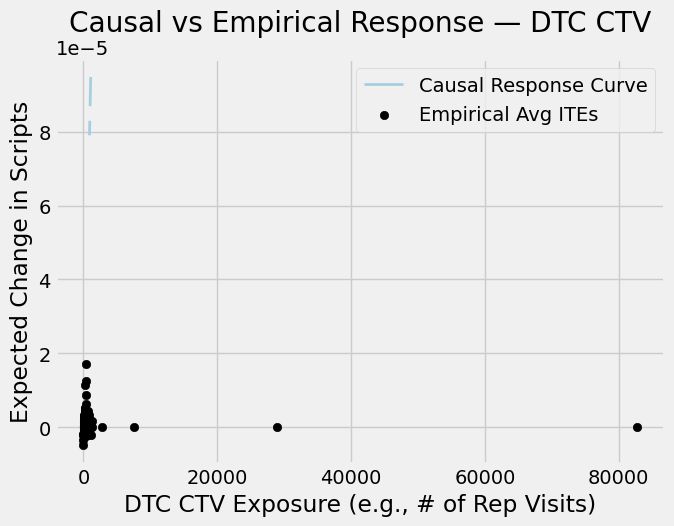

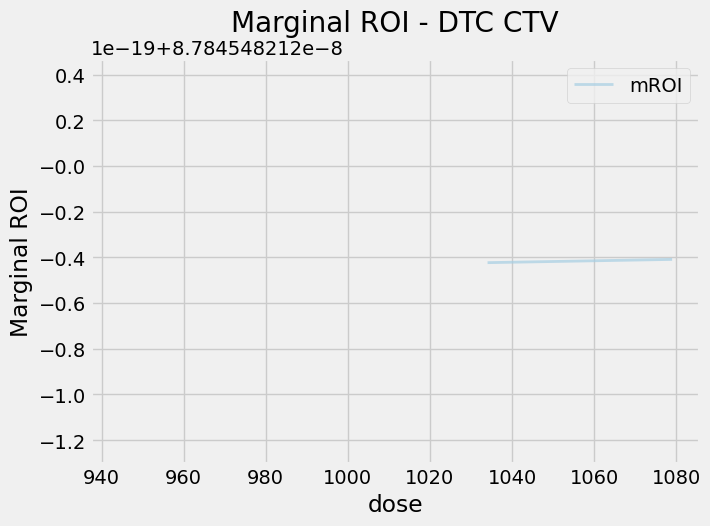

In [ ]:
# Plot causal + empirical response
plot_causal_response_from_df(response_results, channel_name=treatments[1], show_empirical=True)

# Plot marginal ROI
plot_causal_response_from_df(response_results, channel_name=treatments[1], show_mroi=True)